In [1]:

from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding


import numpy as np
from astropy import units as u

from odisseo import construct_initial_state
from odisseo.dynamics import DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams
from odisseo.option_classes import MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.utils import projection_on_GD1

#import flowjax, use for the loss function
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Generate the target simulation 

(-250.0, 250.0)

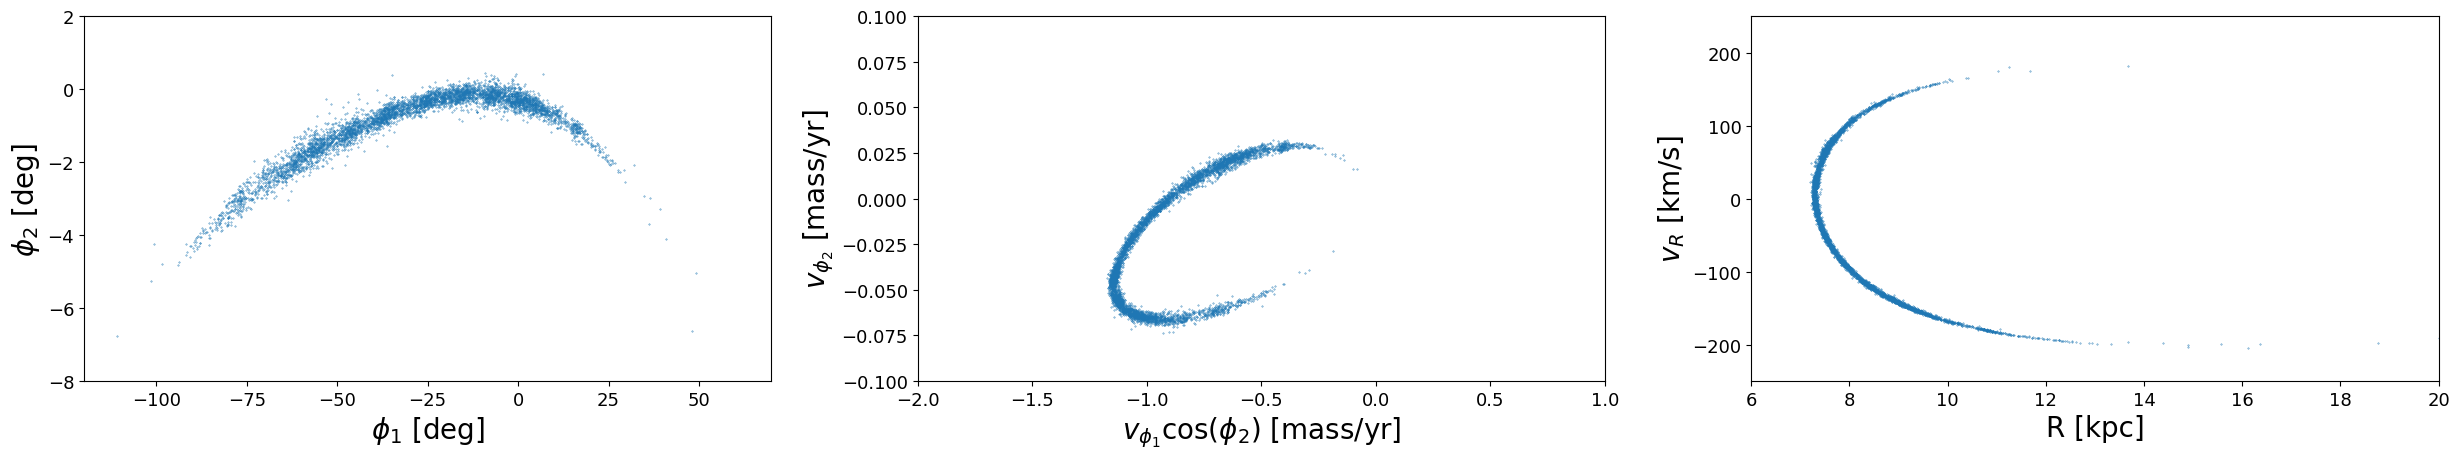

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  

#set the config, we cannot differentiate with respect to the config
config = SimulationConfig(N_particles = 5_000, 
                          return_snapshots = False, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

# set the simulation parameters, we can differentiate with respect to these parameters
params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

#the center of mass has the same config and params as the main simulation but it needs to be integrated backwards in time 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#random key for JAX
key = random.PRNGKey(1)
#Final position and velocity of the center of mass
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
mass_com = jnp.array([params.Plummer_params.Mtot]) 

#we construmt the initial state of the com 
initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
#we run the simulation backwards in time for the center of mass
final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=params_com)
#we calculate the final position and velocity of the center of mass
pos_com = final_state_com[:, 0]
vel_com = final_state_com[:, 1]

#we construct the initial state of the Plummer sphere
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)
#we add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com
#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities, )
#run the simulation
final_state = time_integration(initial_state_stream, mass, config=config, params=params)

#projection on the GD1 stream
stream = projection_on_GD1(final_state, code_units=code_units,)

#plot to check the stream
R = stream[:, 0]  # kpc
phi1 = stream[:, 1]  # deg
phi2 = stream[:, 2]  # deg
vR = stream[:, 3]  # km/s
v1_cosphi2 = stream[:, 4]  # mass/yr
v2 = stream[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


# Add observational noise

This is fully differentiable and jittable, exept for the training, since in the training a varying size array is passed.
In theory its possible to remove this part, but the number of stars is quite large when concatanted with the the selected stream, 
so the training is very long and it would require to change the NaN values with something outside of the observational window and
using a constrained Normalizing Flow (https://danielward27.github.io/flowjax/examples/constrained.html)

  0%|          | 0/100 [00:00<?, ?it/s]2025-06-09 10:36:51.087243: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-09 10:36:51.087294: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-09 10:36:51.087311: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
 12%|█▏        | 12/10

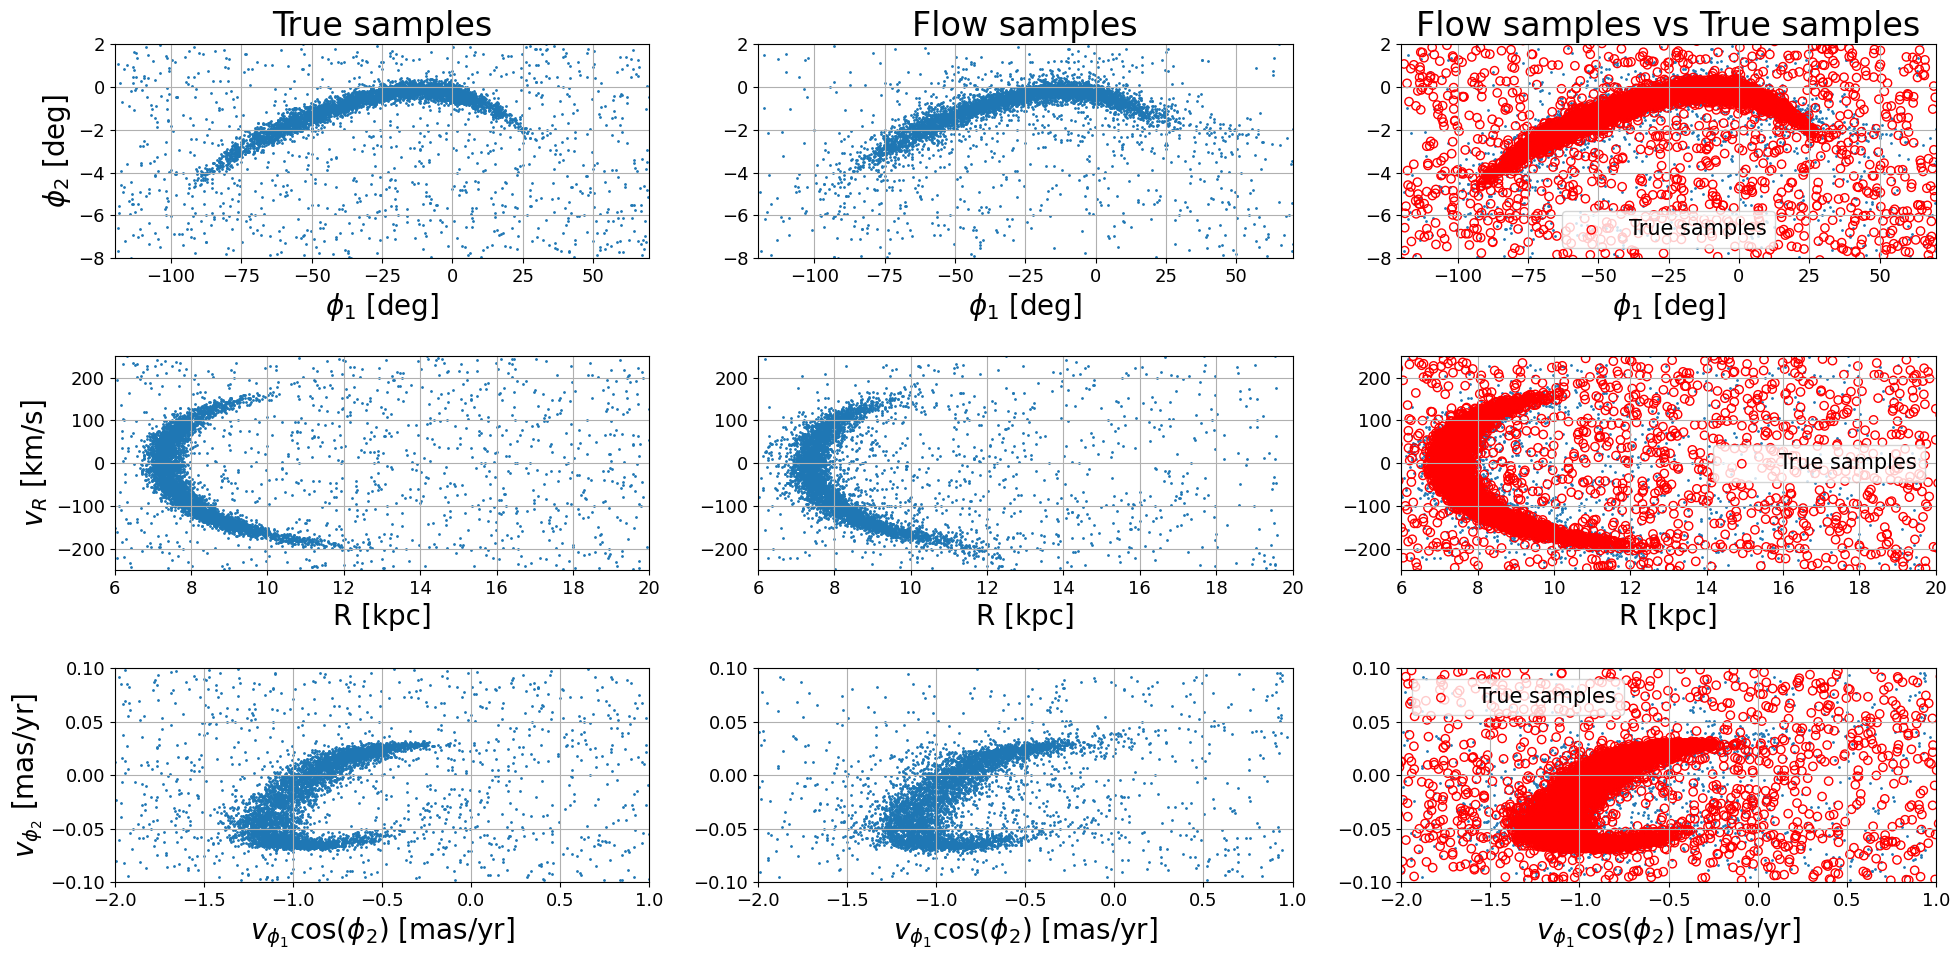

In [3]:
#Bimodal sampling
@jit
def selection_function(stream_star, p, key):
    # Apply selection criteria
    return jnp.where(jax.random.uniform(key=key, shape=1) < p, stream_star, jnp.nan)

# Generate a random background star position
@jit 
def background_assignement(key):
    return jax.random.uniform(key=key, shape=(6,),
                              minval=jnp.array([6, -120, -8, -250, -2., -0.10]),
                             maxval=jnp.array([20, 70, 2, 250, 1.0, 0.10]))

# Select stars from the stream based on Bimodal sampling
key = random.PRNGKey(42)
keys = random.split(key, stream.shape[0])
p = jnp.ones(shape=(stream.shape[0]))* 0.95
selected_stream = jax.vmap(selection_function, )(stream, p, keys)

# Nbackground star contamination
N_background = int(1e6)
#Generate the probability of selectin a background star
background_selected_probability = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
keys = random.split(key, N_background)
selected_background = jax.vmap(lambda key, background_star_probability: jnp.where(background_star_probability, background_assignement(key), jnp.nan))(keys, background_selected_probability)

# Combine the selected stream and background stars
stream = jnp.concatenate((selected_stream, selected_background), axis=0)

#add gaussian noise to the stream, same as in Albatross paper (https://arxiv.org/pdf/2304.02032)
noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std

stream_mean = jnp.nanmean(stream, axis=0)
stream_std = jnp.nanstd(stream, axis=0)
stream = (stream - stream_mean) / stream_std  # Standardize the data

# Assign a new out of the observational windows value to the NaN values, and use constrain support NF, not implemented yet
# stream = jax.vmap(lambda stream_star: jnp.where(jnp.isnan(stream_star), jnp.ones((6))*100, stream_star))(stream)

#rng
rng = jax.random.key(0)

# create the flow
subkey, rng = jax.random.split(rng)
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(stream.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

#we train only on the non NaN values of the stream
key, subkey = jax.random.split(key)
flow, losses = fit_to_data(subkey, flow, stream[~jnp.isnan(stream)].reshape(-1, 6), learning_rate=1e-3)


# Check the flow sampling
stream_plot = stream[~jnp.isnan(stream)].reshape(-1, 6) * stream_std + stream_mean
key, subkey = jax.random.split(jax.random.key(1))
x_samples = flow.sample(subkey, (stream_plot.shape[0],))

# Transform the samples back to the original scale
x_samples_plot = x_samples * stream_std + stream_mean

fig = plt.figure(figsize=(20, 10), tight_layout=True)
ax = fig.add_subplot(331)
ax.scatter(stream_plot[:, 1], stream_plot[:, 2], s=1 )
ax.set_title("True samples")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.grid('dotted')
ax = fig.add_subplot(332)
ax.scatter(x_samples_plot[:, 1], x_samples_plot[:, 2], s=1)
ax.set_title("Flow samples")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.set_xlabel("$\phi_1$ [deg]")
ax.grid('dotted')
ax = fig.add_subplot(333)
ax.set_title("Flow samples vs True samples")
ax.scatter(x_samples_plot[:, 1], x_samples_plot[:, 2], s=1)
ax.scatter(stream_plot[:, 1], stream_plot[:, 2],  marker='o', facecolors='none',  color='r', label='True samples')
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.legend()
ax.set_xlabel("$\phi_1$ [deg]")
ax.grid('dotted')

ax = fig.add_subplot(334)
ax.scatter(stream_plot[:, 0], stream_plot[:, 3],s=1 )
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.grid('dotted')
ax = fig.add_subplot(335)
ax.scatter(x_samples_plot[:, 0], x_samples_plot[:, 3], s=1)
ax.set_xlabel("R [kpc]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.grid('dotted')
ax = fig.add_subplot(336)
ax.scatter(x_samples_plot[:, 0], x_samples_plot[:, 3], s=1)
ax.scatter(stream_plot[:, 0], stream_plot[:, 3], marker='o', facecolors='none', color='r', label='True samples')
ax.set_xlabel("R [kpc]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.legend()
ax.grid('dotted')

ax = fig.add_subplot(337)
ax.scatter(stream_plot[:, 4], stream_plot[:, 5], s=1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")      
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax = fig.add_subplot(338)
ax.scatter(x_samples_plot[:, 4], x_samples_plot[:, 5], s=1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax = fig.add_subplot(339)
ax.scatter(x_samples_plot[:, 4], x_samples_plot[:, 5], s=1)
ax.scatter(stream_plot[:, 4], stream_plot[:, 5], marker='o', facecolors='none', color='r', label='True samples')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax.legend()
plt.tight_layout()


# Differentiable Loss

In [6]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_NFW_mass_grad(Mvir, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)
    key_Plummer, key_selection, key_background, key_noise = random.split(key, 4)
    

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)

    #Stream selection success
    keys_selection = random.split(key_selection, stream.shape[0])
    p = jnp.ones(shape=(stream.shape[0]))* 0.95
    selected_stream = jax.vmap(selection_function, )(stream, p, keys_selection)

    # #background contamination
    N_background = int(1e6)
    # #Generate the probability of selectin a background star, this is computationally expensive, so we just add 1_000 background stars
    # background_selected = jnp.where(jax.random.uniform(key=key_background, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    # keys_background = random.split(key_background, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys_background, background_selected)
    N_background = int(N_background * 1e-3)
    selected_background = jax.vmap(background_assignement, )(random.split(key=key_background, num=N_background))

    # Combine the selected stream and background stars
    stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream
    log_prob = eqx.filter_jit(flow.log_prob)((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = - jnp.sum( jnp.where( jnp.isinf(log_prob), 0., log_prob  )  ) #if the NaN value are passed the value of the log_prob is -inf, we set it to 0 to not contribute to the loss

    return loss


In [8]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = params.NFW_params.Mvir*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 -0.007474702
Loss:
 13401.468
